In [ ]:
import copy
import numpy as np
from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import palettable
import descartes

In [4]:
import verdict

In [5]:
import stained_glass.generate as generate
import stained_glass.idealized as idealized
import stained_glass.stats as stats
import stained_glass.sample as sample

# Computationally Efficient Alternative

Don't use descartes for clumps. Instead choose n random points (where n is calculated based on the area of the clumps and fcov) and use cKDtree to check if a sightline is within distance to them. If not then fall back to descartes.

# Parameters

In [6]:
# Number of sightlines
n = 10000
sidelength = 600.
annuli = np.array([ 20., 100., 200., 300. ])
edges_log = np.logspace( -1., np.log10( sidelength), 64 )
edges = np.linspace( 0., sidelength, 64 )

In [7]:
xs = edges[:-1] + 0.5 * ( edges[1] - edges[0] )

In [8]:
xs_log = 10.**( np.log10( edges_log[:-1] ) + 0.5 * ( np.log10( edges_log[1] ) - np.log10( edges_log[0] ) ) )

In [9]:
n_per_bin = round( n / (edges_log.size - 1 ) / 2 )

# Setup idealized projections

In [10]:
ips = {}
all_length_scales = {}

### Parameters

In [11]:
r_cen = 170.
value_cen = 6.
r_vir = 250.
m_vir = 1e12
r_cen_out = 330.
value_cen_out = 3.

# Satellite
r_sat = 50.
den = value_cen / ( 2. * r_cen )
mass = den * ( 4. / 3. * np.pi * r_cen**3. )
mass_sat = mass / 5.
den_sat = mass_sat / ( 4. / 3. * np.pi * r_sat**3. )
value_sat = den_sat * 2. * r_sat
value_sat = 6.

# Filament
filament_val = 3e7
dx = -400.
theta_b = 100.

# Clumps
dr = 0.5
r_clumps = 10.**np.arange( -0.5, 1. + dr, dr )
f_covs = np.arange( 0.1, 1.0, 0.1 )
clump_val = 5e7

# DEBUG

In [12]:
r_area = np.sqrt( 2. ) * 10.

In [13]:
fcovs = np.linspace( 0., 5., 32 )
r_clumps = np.logspace( -0.5, 0.5, 10 )

32it [00:14,  2.22it/s]
32it [00:13,  2.29it/s]
32it [00:13,  2.29it/s]
32it [00:13,  2.30it/s]
32it [00:13,  2.31it/s]
32it [00:13,  2.31it/s]
32it [00:13,  2.31it/s]
32it [00:13,  2.32it/s]
32it [00:13,  2.34it/s]
32it [00:14,  2.26it/s]


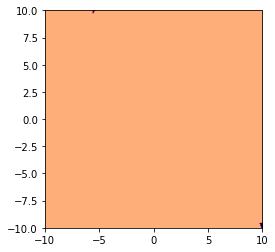

In [14]:
fig = plt.figure()
ax = plt.gca()

all_fcovs = []
for i, r_clump in enumerate( r_clumps ):
    actual_fcovs = []
    for j, fcov in tqdm( enumerate( fcovs ) ):

        ip = idealized.IdealizedProjection()
        ip.add_clumps_nopatch(
            r_clump = r_clump,
            c = ( 0., 0. ),
            r_area = r_area,
            fcov = fcov,
#             verbose = True,
        )

        values = ip.plot_idealized_projection_pixel(
            ax,
            resolution = (256, 256),
        )

        actual_fcov = values.sum() / values.size

        actual_fcovs.append( actual_fcov )
        
    all_fcovs.append( actual_fcovs )

In [25]:
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['xtick.minor.width'] = 1.4
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.width'] = 1.4

matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [26]:
avg_fcov = np.array( all_fcovs ).mean( axis=0 )

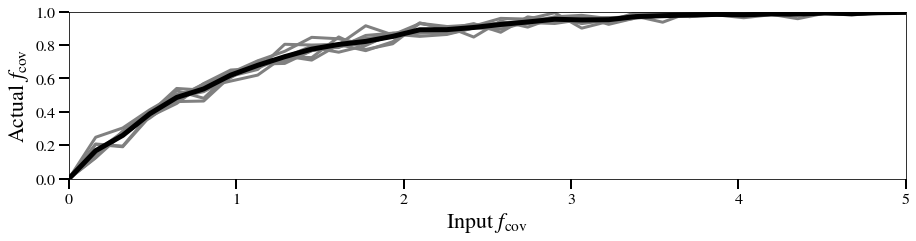

In [27]:
fig = plt.figure( figsize=(15,12), facecolor='w' )
ax = plt.gca()

for i, r_clump in enumerate( r_clumps ):
    ax.plot(
        fcovs,
        all_fcovs[i],
        color = '0.5',
        linewidth = 3,
    )
    
ax.plot(
    fcovs,
    avg_fcov,
    color = 'k',
    linewidth = 5,
)

ax.set_xlabel( r'Input $f_{\rm cov}$', fontsize=22 )
ax.set_ylabel( r'Actual $f_{\rm cov}$', fontsize=22 )

ax.set_xlim( fcovs.min(), fcovs.max() )
ax.set_ylim( 0, 1 )

ax.set_aspect( 'equal' )

In [17]:
avg_fcov

array([0.        , 0.16876831, 0.26004639, 0.38878632, 0.48675842,
       0.53779907, 0.62003326, 0.67873993, 0.73016052, 0.77525024,
       0.80325317, 0.82147522, 0.85156403, 0.89092865, 0.8916626 ,
       0.90480042, 0.92274017, 0.93762512, 0.95396271, 0.94966125,
       0.95125427, 0.96979675, 0.97510681, 0.97924805, 0.98287201,
       0.98005981, 0.98564758, 0.98428802, 0.99099731, 0.98736572,
       0.99303894, 0.99499512])

In [18]:
assert False

AssertionError: 

# END DEBUG

### Control w no clumps

In [ ]:
ip = idealized.IdealizedProjection( sidelength )
ip.add_nfw(
    center = (0., 0.),
    r_vir = r_vir,
    m_vir = m_vir,
    n_annuli = 64,
)
edge_val = min( ip.struct_values )

# Satellite
# ip.add_sphere(
#     c = (-250., 50.),
#     r = r_sat,
#     value = value_sat,
#     n_annuli = 64,
# )

# Filament
ip.add_curve(
    v1 = (0., 0.),
    v2 = (dx, 60.),
    theta_a = 20.,
    theta_b = theta_b,
    value = filament_val,
)
length_scales = {}
width = 40.
n_concentric = 40
ip.add_concentric_structures(
    ip.structs[-1],
    value = filament_val,
    n_concentric = n_concentric,
    dr = width / n_concentric,
    dv = - ( filament_val - edge_val ) / n_concentric
)

length_scales = {}
# length_scales['long'] = np.sqrt( dx**2. + 60.**2. )
length_scales['halo'] = r_vir
length_scales['annuli'] = 100.
# length_scales['satellite'] = r_sat

ips['fcov0.0'] = { 'rclump0.0': ip }
all_length_scales['fcov0.0'] = { 'rclump0.0': length_scales }

### Varying clump radii

In [ ]:
for f_cov in tqdm( f_covs ):
    fcov_key = 'fcov{:.3g}'.format( f_cov )
    fcov_ips = {}
    fcov_ls = {}
    
    for r_clump in tqdm( r_clumps ):
        rclump_key = 'rclump{:.3g}'.format( r_clump )
        
        # Main halo
        ip = idealized.IdealizedProjection(sidelength)
        ip.add_nfw(
            center = (0., 0.),
            r_vir = r_vir,
            m_vir = m_vir,
            n_annuli = 64,
        )
        edge_val = min( ip.struct_values )

        # # Satellite
        # ip.add_sphere(
        #     c = (-250., 50.),
        #     r = r_sat,
        #     value = value_sat,
        #     n_annuli = 64,
        # )

        # Filament
        ip.add_curve(
            v1 = (0., 0.),
            v2 = (dx, 60.),
            theta_a = 20.,
            theta_b = theta_b,
            value = filament_val,
        )
        width = 40.
        n_concentric = 40
        ip.add_concentric_structures(
            ip.structs[-1],
            value = filament_val,
            n_concentric = n_concentric,
            dr = width / n_concentric,
            dv = - ( filament_val - edge_val ) / n_concentric
        )

        # Clumps
        ip.add_clumps(
            r_clump = r_clump,
            c = (0., 0.),
            r_area = r_vir,
            fcov = f_cov,
            value = clump_val,
        )
        length_scales = {}
        # length_scales['long'] = np.sqrt( 300.**2. + 60.**2. )
        length_scales['halo'] = r_vir
        length_scales['clump'] = r_clump
        length_scales['annuli'] = 100.
        
        # Generate projection
        ip.generate_idealized_projection()

        # structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
        # for i, (struct, value) in enumerate( zip( *[ structs, values ] ) ):
        #     width = 10.
        #     n_concentric = 10
        #     ip.add_concentric_structures(
        #         ip.structs[-1],
        #         value = filament_val,
        #         n_concentric = n_concentric,
        #         dr = width / n_concentric,
        #         dv = - ( filament_val - 1. ) / n_concentric
        #     )
        
        fcov_ips[rclump_key] = ip
        fcov_ls[rclump_key] = length_scales
    ips[fcov_key] = fcov_ips
    all_length_scales[fcov_key] = fcov_ls

In [ ]:
ips

# Calculate Metrics

In [ ]:
tpcfs = {}

### Generate Paired Coordinates

In [ ]:
v_edges = np.array([ ip.ip_values.min(), ip.ip_values.max() ])

In [ ]:
pair_sampler = sample.PairSampler( ip.sidelength, edges_log, v_edges )
dr_coords1, dr_coords2 = pair_sampler.generate_pair_sampling_coords(
    n_per_bin = n_per_bin,
)

In [ ]:
pair_coords = np.concatenate([ np.concatenate( dr_coords1 ), np.concatenate( dr_coords2 ) ])

### Calculate pair-sampled, weighted TPCF

In [ ]:
for fcov_key, f_cov_ips in tqdm( ips.items() ):
    tpcfs_fcov = {}
    
    for rclump_key, ip in f_cov_ips.items():
        
        # Get data
        ip.set_sightlines( pair_coords )
        ws = ip.evaluate_sightlines()

        tpcf, edges = stats.weighted_tpcf(
            pair_coords,
            ws,
            edges_log,
        )
    
        tpcfs_fcov[rclump_key] = tpcf
        
    tpcfs[fcov_key] = tpcfs_fcov

# Plot

### Setup

In [ ]:
ncols = 2
nrows = len( ips )

In [ ]:
def label_or_not( label, do_label ):
    
    if do_label:
        return label
    
    return None

In [ ]:
colors = palettable.matplotlib.Viridis_4.mpl_colors[1:][::-1]
arc_color = palettable.cartocolors.qualitative.Pastel_10.mpl_colors[2]

In [ ]:
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['xtick.minor.width'] = 1.4
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.width'] = 1.4

matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

### Projected

In [ ]:
%matplotlib inline

fig = plt.figure( figsize=(3*ncols, 3*nrows), facecolor='w' )
ax = plt.gca()

gs = gridspec.GridSpec( nrows, ncols )
gs.update( wspace=0.0001, hspace=0.0001 )

for i, ip in enumerate( ips ):
    
    # Plot the idealized image
    ax = plt.subplot( gs[i,0], )
    ip.plot_idealized_projection(
        ax,
        cmap = plt.get_cmap( 'Greys_r' ),
        log_color_scale = True,
        vmin = np.log10( 5e5 ),
        vmax = np.log10( 1.5e8 ),
    )
    
    # Fiducial
    ax = plt.subplot( gs[i,1], )
        
    # TPCFs
    tpcf = all_tpcfs[( 'PS', 'W', )][i]
    ax.plot(
        xs_log,
        tpcf,
        linewidth = 6,
        color = 'k',
        label = label_or_not( 'no radial normalization', ax.is_first_col() ),
        zorder = -1,
    )
    
# Go back through and fix up axes
for i in range( ncols ):
    for j in range( nrows ):
        
        ax = plt.subplot( gs[j,i], )
        
        # Projection Plot options
        if i < 1:
            
            ax.set_aspect( 'equal' )
            ax.tick_params( labelleft=False, labelbottom=False, left=False, bottom=False)
            
            if ax.is_first_row():
                ax.set_xlabel( 'column density', fontsize=22 )
                ax.xaxis.set_label_position( 'top' )
            
        # Statistics options
        if i >= 1:
            
            # Length scales
            for key, item in all_length_scales[j].items():
                if key == 'annuli':
                    continue
                    
                ax.axvline(
                    2.*item,
                    linewidth = 1.5,
                    color = '.3',
                    linestyle = '--',
                )
                
                if ax.is_last_row():
                    trans = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes )
                    ax.annotate(
                        s = '2R({})'.format( key ),
                        xy = ( 2.*item, 0 ),
                        xytext = ( 0, -10 ),
                        xycoords = trans,
                        textcoords = 'offset points',
                        va = 'top',
                        ha = 'center',
                        fontsize = 18,
                    )
            
            # Horizontal lines
            for y in np.arange( -1., 1., 0.25 ):
                if np.isclose( y, np.array([ -1., 0., 1. ]) ).sum() != 0:
                    linewidth = 1.5
                elif np.isclose( y, np.array([ -0.5, 0.5, ]) ).sum() != 0:
                    linewidth = 1.25
                else:
                    linewidth = 0.5
                ax.axhline(
                    y,
                    color = '0.1',
                    linewidth = linewidth,
                )
            
            # Remove tick labels
            ax.tick_params( labelleft=False, left=False, labelright=True, right=True, top=True, labelbottom=False, direction='inout' )
            if ax.is_first_row():
                ax.tick_params( labeltop=True, )
            ax.tick_params( which='minor', direction='inout', bottom=True, top=True, )
            
            # Avosid overlapping labels
            ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
            ax.get_yticklabels()[-1].set_verticalalignment( 'top' )
            
            # Axis tweaks
            ax.set_xlim( 0.9, xs_log[-1] )
            ax.set_xscale( 'log' )
            
            # Make sure enough ticks show up
            locmaj = matplotlib.ticker.LogLocator( base=10, numticks=12 ) 
            ax.xaxis.set_major_locator( locmaj )
            locmin = matplotlib.ticker.LogLocator( base=10.0, subs=np.arange( 0.1, 1., 0.1), numticks=12 )
            ax.xaxis.set_minor_locator( locmin )
            ax.xaxis.set_minor_formatter( matplotlib.ticker.NullFormatter() )
            
            # Format more nicely
            replacements = {
                1.: '1',
                10.: '10',
                100.: '100',
            }
            new_labels = []
            for ii, old_label in enumerate( ax.get_xticklabels() ):
                label = old_label
                for val, s in replacements.items():
                    if np.isclose( ax.get_xticks()[ii], val ):
                        label = s
                        break            
                new_labels.append( label )
            ax.set_xticklabels( new_labels )

            if ax.is_first_row():
                ax.set_xlabel( r'$\delta$ (kpc)', fontsize=22 )
                ax.xaxis.set_label_position( 'top' )
            ax.set_ylabel( r'$\Xi$', fontsize=22, rotation=0 )
            ax.yaxis.set_label_position( 'right' )
            
#             # Legend
#             if ax.is_first_col():
#                 ax.legend(
#                     bbox_to_anchor = (0.0, 2.02, 5., 0.5 ),
#                     loc = 'lower left',
#                     ncol = 4,
#                     mode = "expand",
#                     borderaxespad = 0.,
#                     prop = {'size': 16},
#                 )

# lgd = fig.legend(
# #     bbox_to_anchor = (0.1, 0.87, 0.7, 1.0 ),
#     loc = 'lower left',
#     ncol = 4,
#     mode = "expand",
#     borderaxespad = 0.,
#     prop = {'size': 16},
# )

fig.savefig('./weighted_correlations.pdf', bbox_inches='tight')

### Same Axis TPCF

In [ ]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

for i, tpcf in enumerate( all_tpcfs[('PS', 'W')] ):
    
    # TPCFs
    ax.plot(
        xs_log,
        tpcf,
        linewidth = 6,
        color = 'k',
        label = i,
        zorder = -1,
    )
    
# Axis tweaks
ax.set_xlim( 0.9, xs_log[-1] )
ax.set_xscale( 'log' )
ax.set_ylim( -0.5, 1. )